# Домашнее задание к уроку 3.

In [126]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from linear_regression import linear_regression
from sklearn.linear_model import LinearRegression as sklearn_LR
from sklearn import datasets
from scipy.stats import norm
%matplotlib inline

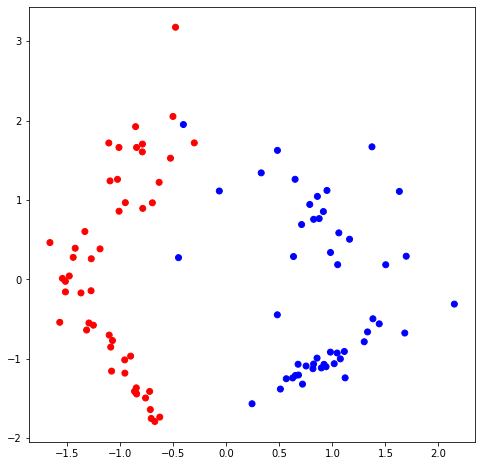

In [127]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [128]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [129]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    @staticmethod
    def log_grad(w, c, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, w.T).flatten()
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    @classmethod
    def optimize(cls, w, c, X, y, n_iterations, eta):
        for i in range(n_iterations):        
            grad_w, grad_c = cls.log_grad(w, c, X, y)
            w = w - eta * grad_w
            c = c - eta * grad_c
        return w, c
    def fit(self, X, y):
        w0 = np.zeros((1, X.shape[1]))
        c0=0
        self.w, self.c= self.optimize(w0, c0, X, y, self.n_iterations, self.eta)
    def predict_proba(self, X):  
        score=X.dot(self.w.T).flatten()+self.c
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [130]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.32402389 0.01235587]]
Точность на обучающей выборке: 97.143
Точность на тестовой выборке: 96.667


In [131]:
""" МАТРИЦА ОШИБОК """
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [132]:
print("Для порога по вероятности 0.5 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test), y_test)}")
print("Для порога по вероятности 0.75 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.75), y_test)}")

Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 15, 'FP': 0, 'FN': 1, 'TN': 14}
Для порога по вероятности 0.75 на тестовой выборке имеем: {'TP': 0, 'FP': 0, 'FN': 16, 'TN': 14}


In [133]:
cofusion_fixed=confusion(mod.predict(X_test), y_test)
sensitivity=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FN'])
specificity=cofusion_fixed['TN']/(cofusion_fixed['TN']+cofusion_fixed['FP'])
balanced_accuracy=(sensitivity+specificity)/2
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность {sensitivity},"+
      f"специфичность {specificity}, сбалансированную точность {balanced_accuracy}")

Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность 0.9375,специфичность 1.0, сбалансированную точность 0.96875


In [134]:
precision=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FP'])
recall=sensitivity
f1_score=2*precision*recall/(precision+recall)
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: точность {precision},"+
      f"полноту {recall}, f1-скор {f1_score}")

Для порога по вероятности 0.5 на тестовой выборке имеем: точность 1.0,полноту 0.9375, f1-скор 0.967741935483871


In [135]:
x=X_test
targets=y_test

In [136]:
num_pos=np.sum(targets)
num_neg=len(targets)-num_pos
print(f'{num_pos} объектов положительного класса, {num_neg} объектов негативного класса')

16 объектов положительного класса, 14 объектов негативного класса


In [137]:
#Чувствительность
TPR=np.concatenate([[0], np.cumsum(1-targets)/num_neg])

#Ложно-позитивный уровень
FPR=np.concatenate([[0], np.cumsum(targets)/num_pos])

In [138]:
TPR

array([0.        , 0.07142857, 0.07142857, 0.14285714, 0.14285714,
       0.21428571, 0.21428571, 0.21428571, 0.21428571, 0.21428571,
       0.21428571, 0.28571429, 0.28571429, 0.35714286, 0.35714286,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.57142857,
       0.57142857, 0.57142857, 0.64285714, 0.71428571, 0.78571429,
       0.78571429, 0.85714286, 0.92857143, 0.92857143, 1.        ,
       1.        ])

In [139]:
FPR

array([0.    , 0.    , 0.0625, 0.0625, 0.125 , 0.125 , 0.1875, 0.25  ,
       0.3125, 0.375 , 0.4375, 0.4375, 0.5   , 0.5   , 0.5625, 0.625 ,
       0.625 , 0.625 , 0.625 , 0.6875, 0.75  , 0.8125, 0.8125, 0.8125,
       0.8125, 0.875 , 0.875 , 0.875 , 0.9375, 0.9375, 1.    ])

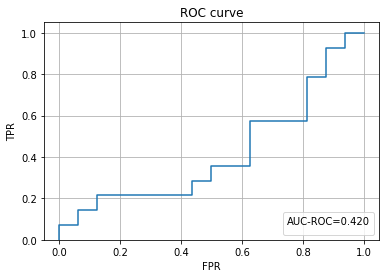

In [140]:
AUC_ROC = np.sum(0.5*(FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1]))

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

In [141]:
precision=np.cumsum(1-targets)/(np.cumsum(1-targets)+np.cumsum(targets))
precision

array([1.        , 0.5       , 0.66666667, 0.5       , 0.6       ,
       0.5       , 0.42857143, 0.375     , 0.33333333, 0.3       ,
       0.36363636, 0.33333333, 0.38461538, 0.35714286, 0.33333333,
       0.375     , 0.41176471, 0.44444444, 0.42105263, 0.4       ,
       0.38095238, 0.40909091, 0.43478261, 0.45833333, 0.44      ,
       0.46153846, 0.48148148, 0.46428571, 0.48275862, 0.46666667])

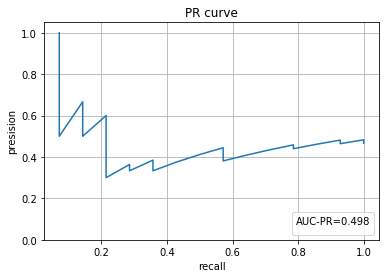

In [142]:
recall = TPR
AUC_PR = np.sum(precision*(TPR[1:]-TPR[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)